# Import Packages and functions

C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\FunctionsAndClass.py:12: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


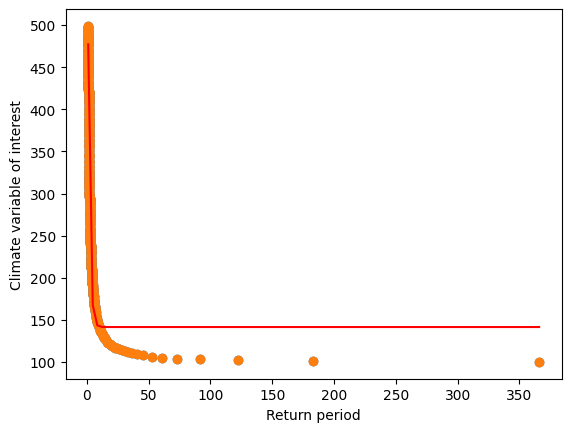

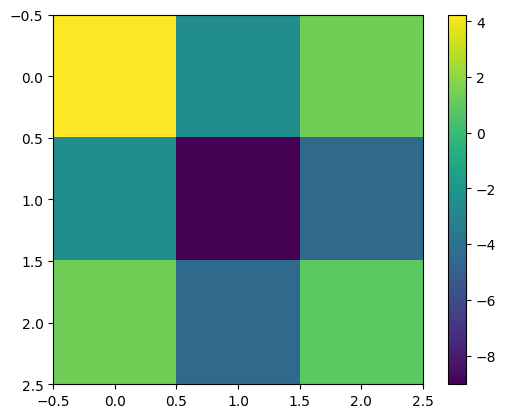

In [1]:
import requests
import pandas as pd

import os
import os.path

from netCDF4 import Dataset


import numpy as np
import numpy.ma as ma

import multiprocessing as mp# to download several file in parrallel
from multiprocessing.pool import ThreadPool

from FileManagement import produce_name_list
from FunctionsAndClass import year_copernicus
from FileManagement import find_path_file
from FileManagement import find_column_name
from FileManagement import time_vector_conversion
from FileManagement import create_dataframe
from FileManagement import data_information

# Projects information


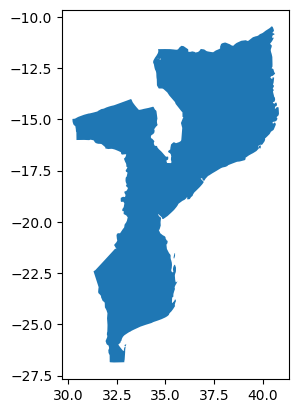

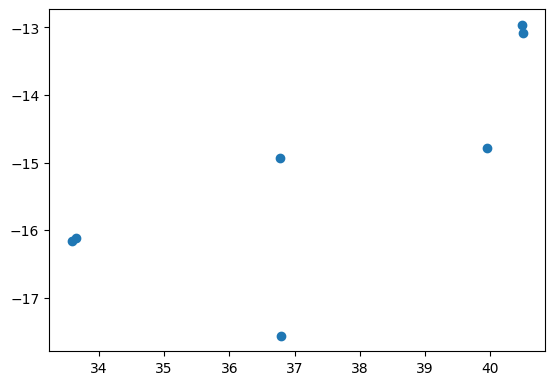

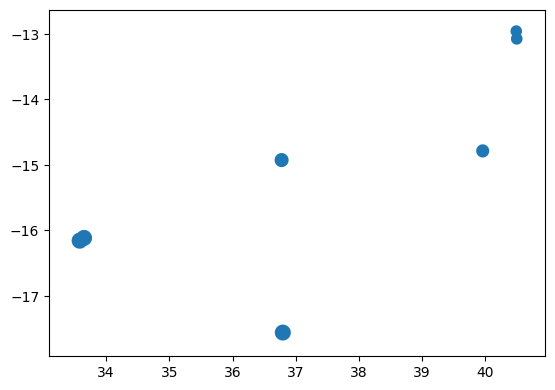

In [2]:
import geopandas as gpd
import os
import os.path

data_folder=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets'
project_location_path=os.path.join(data_folder,'Mozambique_PPIS/EIB_locations_few.shp')
#study boundary (optional)
study_area_path=os.path.join(data_folder,'Mozambique_PPIS/mozambique.shp')


#projection CRS (default = 'EPSG:4326')
bCRS='EPSG:4326'

#buffer for climate/grid variables
buffer=40000 #buffer in meters, 0 = no buffer is computed

mCRS='EPSG:31983' #metric CRS for buffer in meters (find relevant metric CRS for location!)

#load shapefiles
projects = gpd.read_file(project_location_path).to_crs(bCRS)
project_id='Name' #name of column used as id

study_area = gpd.read_file(study_area_path).to_crs(bCRS)

#calculate buffer around points/shape
if buffer != 0:
    projects_buf=projects.to_crs(mCRS)  #project to crs with metric units to get buffer in meters
    projects_buf['geometry']=projects.to_crs(mCRS).buffer(buffer) #assign the buffer as the new geometry - 
    projects_buf=projects_buf.to_crs(bCRS)#project back to orginal crs

    
#plot shapefiles
study_area.plot()
projects.plot()
projects_buf.plot() 


#show table
projects[[project_id]]

# register geographic information concerning projects
lon_projects = projects['geometry'].x
lat_projects = projects['geometry'].y
buf_projects = 0.3
area_projects = [lat_projects - buf_projects, lat_projects+buf_projects, lon_projects-buf_projects,lon_projects+buf_projects] # list format
#### determination of the geographical zone of interest 
lat_min_wanted = min(study_area['LAT'])-10
lat_max_wanted = max(study_area['LAT'])+10
lon_min_wanted = min(study_area['LON'])-20
lon_max_wanted = max(study_area['LON'])+20
# addind and substracting to lon and lat to have margin
# substracting more to longitude because the range of longitude is -180 to 180. The range of latitude is -90 to 90

# Define Paths

In [3]:
out_path=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6'

# Complete list of url with files to download

In [4]:
# register information from csv file
#all_urls = pd.read_csv(r'C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\NEX-GDDP-CMIP6\gddp-cmip6-thredds-fileserver.csv')
csv_path = os.path.join(out_path,'gddp-cmip6-thredds-fileserver.csv')
all_urls = pd.read_csv(csv_path)

In [5]:
### make all elements of the csv into a readable list

temp_list = all_urls[[' fileUrl']].T# transpose csv
temp_list=temp_list.values.tolist()
temp_list=temp_list[0]
url_list=[s.replace(' ', '') for s in temp_list]

In [6]:
## download only precipitation data
# select only precipitation files, between 2040 and 2080
url_list_precipitation = [url for url in url_list if 'pr_day_' in url and int(url[len(url)-7:len(url)-3])>2020 and int(url[len(url)-7:len(url)-3])<2061 and 'r1i1p1f1_gn' in url]

In [7]:
len(url_list_precipitation)

2360

In [8]:
name_list_precipitation = produce_name_list(url_list_precipitation)

# Produce csv files with data to use

In [9]:
(year, year_str, index_year) = year_copernicus(2021,2060)

In [10]:
variables= []
time_aggregations= []
models= []
scenarios= []
for file_name in name_list_precipitation:
    (variable, time_aggregation, model, scenario, year) = data_information(file_name) 
    # use function data_information to find information concerning the file_name
    if variable not in variables:
        variables.append(variable)
    if time_aggregation not in time_aggregations:
        time_aggregations.append(time_aggregation)
    if model not in models:
        models.append(model)
    if scenario not in scenarios:
        scenarios.append(scenario)
title_file = variable +'_'+year_str[0] +'_'+year_str[len(year_str)-1]
name_variable = 'pr_day'

In [ ]:
# 16 donnees pour chaque point si buf_projects = 0.5
# 1 si buf_projects = 0.1
# 9 si buf_projects = 0.3

# pourquoi certains files ne trouve pas leur model ???
i = 1
title_file = projects['Name'][i]+'_2021-2060'
area_project = [area_projects[0][i],area_projects[1][i],area_projects[2][i],area_projects[3][i]]
create_dataframe(name_list_precipitation,'daily',year_str,scenarios,models,out_path, name_variable, projects['Name'][i],area_project,'2021-2060',title_file) 

In [11]:
# unit of the variable of interest
path_1 = os.path.join(out_path,name_list_precipitation[0])
Dataset(path_1).variables['pr'].units

'kg m-2 s-1'

In [12]:
# resolution donnees ?
path_1 = os.path.join(out_path,name_list_precipitation[0])
Dataset(path_1) # resolution : 0.25 degree
lat_dataframe = np.ma.getdata(Dataset(path_1).variables['lat']).data # len = 600
lon_dataframe = np.ma.getdata(Dataset(path_1).variables['lon']).data # len = 1400

In [13]:
resolution_lat=np.diff(lat_dataframe)
resolution_lat[resolution_lat!=0.25]

array([], dtype=float64)

In [14]:
resolution_lon = np.diff(lon_dataframe)
resolution_lon[resolution_lon!=0.25]

array([], dtype=float64)

In [15]:
from FileManagement import find_index_project
from FileManagement import find_column_name
column_name = find_column_name(path_1)
index_lat_project=find_index_project(lat_dataframe,area_projects[0][0],area_projects[1][0])
index_lon_project=find_index_project(lon_dataframe,area_projects[2][0],area_projects[3][0])
lat_dataframe =lat_dataframe[index_lat_project]
lon_dataframe =lon_dataframe[index_lon_project]

data_with_all = ma.getdata(Dataset(path_1).variables[column_name]).data

data_with_all=data_with_all[:,index_lat_project,:]
data_with_all=data_with_all[:,:,index_lon_project]

In [16]:
data_with_all

array([[[5.4781096e-05, 7.1160903e-05, 8.8911715e-05],
        [4.4411405e-05, 5.8532161e-05, 7.4220443e-05],
        [3.4734487e-05, 4.7852758e-05, 6.2248444e-05]],

       [[2.3055194e-04, 2.2593190e-04, 2.2570109e-04],
        [2.0827954e-04, 2.0398354e-04, 2.0503270e-04],
        [1.9062034e-04, 1.9027444e-04, 1.9351352e-04]],

       [[7.0555929e-05, 9.6080046e-05, 1.2334502e-04],
        [6.5834363e-05, 8.8340828e-05, 1.1310288e-04],
        [6.2683321e-05, 8.4258420e-05, 1.0798056e-04]],

       ...,

       [[1.7262613e-04, 1.7038385e-04, 1.7173008e-04],
        [1.6322118e-04, 1.6637152e-04, 1.7427160e-04],
        [1.5800050e-04, 1.7038173e-04, 1.8650264e-04]],

       [[4.8196529e-05, 4.7796584e-05, 4.8388370e-05],
        [7.3183102e-05, 7.2407936e-05, 7.3660456e-05],
        [1.0161212e-04, 1.0233877e-04, 1.0508698e-04]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0

In [17]:
lat_dataframe

array([-16.375, -16.125, -15.875])

In [18]:
import geopy.distance

coords_1 = (lat_dataframe[0], lon_dataframe[0]) # lat, lon
coords_2 = (lat_dataframe[1], lon_dataframe[1])

print(geopy.distance.geodesic(coords_1, coords_2).km)

38.46554060645643


In [19]:
import geopy.distance

coords_1 = (lat_dataframe[2], lon_dataframe[2]) # lat, lon
coords_2 = (lat_dataframe[1], lon_dataframe[1])

print(geopy.distance.geodesic(coords_1, coords_2).km)

38.48837600720563


In [ ]:
# make one csv file for each projects
# create a new file name each time for each projet
for i in np.arange(0,len(projects['Name'])):
    title_file = projects['Name'][i]+'_2021-2060'
    area_project = [area_projects[0][i],area_projects[1][i],area_projects[2][i],area_projects[3][i]]
    create_dataframe(name_list_precipitation,'daily',year_str,scenarios,models,out_path, name_variable, projects['Name'][i],area_project,'2021-2060',title_file) 

In [96]:
type(scenarios)

list

In [98]:
scenarios = [scenarios[0]]

In [99]:
scenarios

['ssp245']

In [ ]:
# make one csv file for each projects
# create a new file name each time for each projet
#for i in np.arange(0,len(projects['Name'])):
i = 1
scenarios = [scenarios[0]]
models = [models[0]]
title_file = projects['Name'][i]+'_2021-2060'
area_project = [area_projects[0][i],area_projects[1][i],area_projects[2][i],area_projects[3][i]]
create_dataframe(name_list_precipitation,'daily',year_str,scenarios,models,out_path, name_variable, projects['Name'][i],area_project,'2021-2060',title_file) 

In [ ]:
Datset

In [35]:
# test with zonal_stats
from FunctionsAndClass import read_cckp_ncdata
import rioxarray
from rasterstats import zonal_stats
output = 'tempfile.tif'
with rioxarray.open_rasterio(path_1) as ncdata:
    ncdata.rio.write_crs('EPSG:4326', inplace=True)
    ncdata=ncdata.isel(time=0)
    data=ncdata.rio.to_raster(output)
#data=read_cckp_ncdata(path_1)
stats=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=data,all_touched=True, stats='mean'))

TypeError: invalid path or file: None

In [37]:
path_1

'\\\\COWI.net\\projects\\A245000\\A248363\\CRVA\\Datasets\\NEX-GDDP-CMIP6\\pr_day_ACCESS-CM2_ssp245_r1i1p1f1_gn_2021.nc'

In [94]:
import netCDF4
import geopandas as gpd

# Path to the NetCDF file
nc_file = path_1

# Path to the shapefile
shapefile = project_location_path

# Open the NetCDF file
nc = netCDF4.Dataset(nc_file)

# Load the shapefile
gdf = gpd.read_file(shapefile)

# Extract coordinates from shapefile
points = gdf.geometry.centroid

# Get the variables from the NetCDF file
variable_names = nc.variables.keys()

# Iterate over the variables
for var_name in variable_names:
    var_data=np.ma.getdata(nc.variables['pr'][:]).data # Read the variable data
    # Iterate over the points in the shapefile
    for point in points:
        lon, lat = point.x, point.y

        # Find the corresponding indices in the NetCDF file
        #lon_index = netCDF4.chartostring(np.ma.getdata(nc.variables['lon'][:]).data).tolist().index(str(lon))
        #lat_index = netCDF4.chartostring(np.ma.getdata(nc.variables['lat'][:]).data).tolist().index(str(lat))
        
        lon_index = np.where(np.ma.getdata(nc.variables['lon'][:]).data < (lon + 0.1))
        lon_index = np.where(lon_index > (lon - 0.1))[1]
        
        lat_index = np.where(np.ma.getdata(nc.variables['lat'][:]).data < (lat + 0.1))
        lat_index = np.where(lat_index > (lat - 0.1))[1]

        #lat_index = np.where((np.ma.getdata(nc.variables['lat'][:]).data < (lat + 0.1)) and (np.ma.getdata(nc.variables['lat'][:]).data > (lat - 0.1)))#[0][0]

        
        # Extract the data at the specific lon/lat indices
        point_data = var_data[:, lat_index, lon_index]
        # Do whatever you want with the extracted data for each point
        print(f"Variable: {var_name}, Point: ({lon}, {lat}), Data: {point_data}")

# Close the NetCDF file
nc.close()

RuntimeError: NetCDF: HDF error

In [79]:
lon_index[1]

array([ 34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,
        47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
        60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134], dtype=int64)

In [42]:
import netCDF4
import geopandas as gpd

# Path to the NetCDF file
nc_file = path_1

# Path to the shapefile
shapefile = project_location_path

# Open the NetCDF file
nc = netCDF4.Dataset(nc_file)

# Load the shapefile
gdf = gpd.read_file(shapefile)

# Extract coordinates from shapefile
points = gdf.geometry.centroid

# Get the variables from the NetCDF file
variable_names = nc.variables.keys()

In [60]:
names_1=[]
for var_name in variable_names:
    print(type(var_name))
    names_1.append(var_name)
    data=nc.variables[var_name][:]

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [57]:
names_1

['time', 'pr', 'lat', 'lon']

In [50]:
var_data=np.ma.getdata(nc.variables['time'][:]).data

In [65]:
nc.variables['lon'][:]

masked_array(data=[1.25000e-01, 3.75000e-01, 6.25000e-01, ...,
                   3.59375e+02, 3.59625e+02, 3.59875e+02],
             mask=False,
       fill_value=1e+20)

In [66]:
np.ma.getdata(nc.variables['lon'][:]).data

In [93]:
Dataset(path_1).variables['pr'][0,0,0]

RuntimeError: NetCDF: HDF error

In [87]:
lat

-16.1180719828059